On importe les bibliothèques nécessaires à l'implémentation du modèle linéaire

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score , accuracy_score , recall_score , roc_auc_score, precision_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold

On charge la base de données sur laquelle on va travailler et on la met en forme

In [18]:
path="/Users/capucinerousset/Desktop/statapp_sujet26/"
file_name1="dataset_complet_part_1.csv"
file_name2="dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','dep','v2','pr','pr1'])
#ici on enlève an car on ne regarde que pour 2019
df['hrmn'] = df['hrmn'].str.split(':').str[0]

df.to_csv('lin.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns


<class 'pandas.core.series.Series'>


On implémente le modèle de régression linéaire

In [7]:
# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Inférer les valeurs non renseignées
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

#Ajuster Y pour fitter avec la nouvelle base de features
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

#Créer le modèle linéaire et l'entrainer sur les bases test
model = LinearRegression()
model.fit(X_train_imp, y_train)

#Tester le modèle sur la base de features test
y_pred = model.predict(X_test_imp)

for i in range(len(y_pred)):
    if y_pred[i]>(1/2):
        y_pred[i]=int(1)
    else: y_pred[i]=int(0)
    

On calcule le R2 afin de mesurer la performance du modèle

In [30]:
# Évaluer les performances du modèle
f1 = f1_score(y_test, y_pred)
print("F1:", f1)
R2 = mean_squared_error(y_test, y_pred)
print("MSE:", R2)


F1: 0.4932354078082721
MSE: 0.29707681849082257


In [12]:
# On récupère les coefficients
coefficients = model.coef_

# Les associer à leur feature 
feature_importance = list(zip(features, coefficients))
# Trier les coefficients par valeur absolue
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Afficher les 10 coefficients les plus importants
print("10 most important coefficients:")
for i in range(10):
    feature, importance = feature_importance_sorted[i]
    print(f"{feature}: {importance}")

10 most important coefficients:
agg: -0.2660160556012651
v1: 0.08648651037491518
nbv: -0.05570166328749759
circ: 0.049931319955786126
situ: 0.039732965336483385
plan: 0.03858448924666496
catr: 0.02319058924461179
prof: 0.018051789407435768
col: 0.01498705866469151
surf: -0.011963870398099933


On refait le modèle avec cross validation 

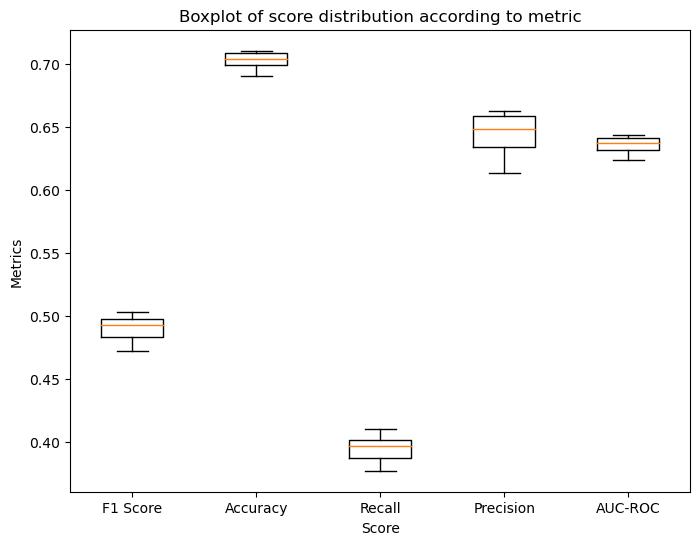

In [28]:
skf = StratifiedKFold(n_splits=20, random_state=42, shuffle=True)

lr_model = LinearRegression()

f1s= []
accuracies =[]
recalls=[]
precisions=[]
auc_rocs=[]



# Iterate through each fold
for train_index, test_index in skf.split(X, y):
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imp2 = imputer.fit_transform(X_train2)
    X_test_imp2 = imputer.transform(X_test2)
    
    # Fit the model
    lr_model.fit(X_train_imp2, y_train2)
    
    # Predict on the test set
    y_pred2 = lr_model.predict(X_test_imp2)

    for i in range(len(y_pred2)):
        if y_pred2[i]>(1/2):
            y_pred2[i]=int(1)
        else: y_pred2[i]=int(0)

    accuracy = accuracy_score(y_test2, y_pred2)
    recall = recall_score(y_test2, y_pred2)
    precision = precision_score(y_test2, y_pred2)
    auc_roc = roc_auc_score(y_test2, y_pred2)

    f1s.append(f1_score(y_pred2,y_test2))
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    auc_rocs.append(auc_roc)

plt.figure(figsize=(8, 6))
plt.boxplot([f1s, accuracies, recalls, precisions, auc_rocs],
            labels=['F1 Score', 'Accuracy', 'Recall', 'Precision', 'AUC-ROC'])
plt.xlabel('Score')
plt.ylabel('Metrics')
plt.title('Boxplot of score distribution according to metric')
plt.show()

